# MCMC

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install pymc3==3.10
    !pip install arviz==0.11.0

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

For most of this book we've been using grid methods to approximate posterior distributions.
For models with one or two parameters, grid algorithms are fast and the results are precise enough for most practical purposes.
With three parameters, they start to be slow, and with more than three they are usually not practical.

In the previous chapter we saw that we can solve some problems using conjugate priors.
But the problems we can solve this way tend to be the same ones we can solve with grid algorithms.

For problems with more than a few parameters, the most powerful tool we have is MCMC, which stands for "Markov chain Monte Carlo".
In this context, "Monte Carlo" refers to to methods that generate random samples from a distribution.
Unlike grid methods, MCMC methods don't try to compute the posterior distribution; they sample from it instead.

It might seem strange that you can generate a sample without ever computing the distribution, but that's the magic of MCMC.

To demonstrate, we'll start by solving the World Cup problem.
Yes, again.


## The World Cup Problem

In <<_PoissonProcesses>> we modeled goal scoring in football (soccer) as a Poisson process characterized by a goal-scoring rate, denoted $\lambda$.

We used a gamma distribution to represent the prior distribution of $\lambda$, then we used to outcome of the game to compute the posterior distribution for both teams.

To answer the first question, we used the posterior distributions to compute the "probability of superiority" for France.

To answer the second question, we computed the posterior predictive distributions for each team, that is, the distribution of goals we expect in a rematch.

In this chapter we'll solve this problem again using PyMC3, which is a library that provide implementations of several MCMC methods.
But we'll start by reviewing the grid approximation of the prior and the prior predictive distribution.

## Grid Approximation

As we did in <<_TheGammaDistribution>> we'll use a gamma distribution with parameter $\alpha=1.4$ to represent the prior.

In [4]:
from scipy.stats import gamma

alpha = 1.4
prior_dist = gamma(alpha)

I'll use `linspace` to generate possible values for $\lambda$, and `pmf_from_dist` to compute a discrete approximation of the prior.

In [5]:
import numpy as np
from utils import pmf_from_dist

lams = np.linspace(0, 10, 101)
prior_pmf = pmf_from_dist(prior_dist, lams)

We can use the Poisson distribution to compute the likelihood of the data; as an example, we'll use 4 goals.

In [6]:
from scipy.stats import poisson

data = 4
likelihood = poisson.pmf(data, lams)

Now we can do the update in the usual way.

In [7]:
posterior = prior_pmf * likelihood
posterior.normalize()

0.05015532557804499

Soon we will solve the same problem with PyMC3, but first it will be useful to introduce something new: the prior predictive distribution.

## Prior Predictive Distribution

We have seen the posterior predictive distribution in previous chapters; the prior predictive distribution is similar except that (as you might have guessed) it is based on the prior.

To estimate the prior predictive distribution, we'll start by drawing a sample from the prior.

In [8]:
sample_prior = prior_dist.rvs(1000)

The result is an array of possible values for the goal-scoring rate, $\lambda$.
For each value in `sample_prior`, I'll generate one value from a Poisson distribution.

In [9]:
from scipy.stats import poisson

sample_prior_pred = poisson.rvs(sample_prior)

`sample_prior_pred` is a sample from the prior predictive distribution.
To see what it looks like, we'll compute the PMF of the sample.

In [10]:
from empiricaldist import Pmf

pmf_prior_pred = Pmf.from_seq(sample_prior_pred)

And here's what it looks like:

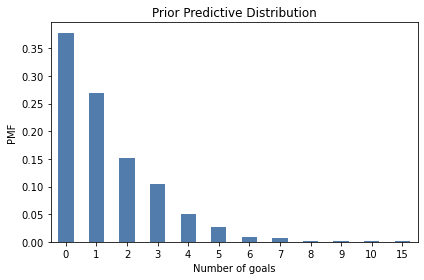

In [11]:
from utils import decorate

pmf_prior_pred.bar()
decorate(xlabel='Number of goals',
         ylabel='PMF',
         title='Prior Predictive Distribution')

One reason to compute the prior predictive distribution is to check whether our model of the system seems reasonable.
In this case, the distribution of goals seems consistent with what we know about World Cup football.

But in this chapter we have another reason: computing the prior predictive distribution is a first step toward using MCMC.

## Introducing PyMC3

PyMC3 is a Python library that provides several MCMC methods.
To use PyMC3, we have to specify a model of the process that generates the data.
In this example, the model has two steps:

* First we draw a goal-scoring rate from the prior distribution,

* Then we draw a number of goals from a Poisson distribution.

Here's how we specify this model in PyMC3:

In [12]:
import pymc3 as pm

with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

After importing `pymc3`, we create a `Model` object named `model`.

If you are not familiar with the `with` statement in Python, it is a way to associate a block of statements with an object.
In this example, the two indented statements are associated with the new `Model` object.  As a result, when we create the distribution objects, `Gamma` and `Poisson`, they are added to the `Model`.

Inside the `with` statement:

* The first line creates the prior, which is a gamma distribution with the given parameters.

* The second line creates the prior predictive, which is a Poisson distribution with the parameter `lam`.

The first parameter of `Gamma` and `Poisson` is a string variable name.

PyMC3 provides a function that generates a visual representation of the model.

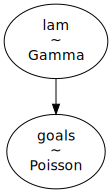

In [13]:
pm.model_to_graphviz(model)

In this visualization, the ovals show that `lam` is drawn from a gamma distribution and `goals` is drawn from a Poisson distribution.
The arrow shows that the values of `lam` are used as parameters for the distribution of `goals`.

## Sampling the Prior

PyMC3 provides a function that generates samples from the prior and prior predictive distributions.
We can use a `with` statement to run this function in the context of the model.

In [14]:
with model:
    trace = pm.sample_prior_predictive(1000)

The result is a dictionary-like object that maps from the variables, `lam` and `goals`, to the samples.
We can extract the sample of `lam` like this:

In [15]:
sample_prior_pymc = trace['lam']
sample_prior_pymc.shape

(1000,)

The following figure compares the CDF of this sample to the CDF of the sample we generated using the `gamma` object from SciPy.

In [16]:
from empiricaldist import Cdf

def plot_cdf(sample, **options):
    """Plot the CDF of a sample.
    
    sample: sequence of quantities
    """
    Cdf.from_seq(sample).plot(**options)

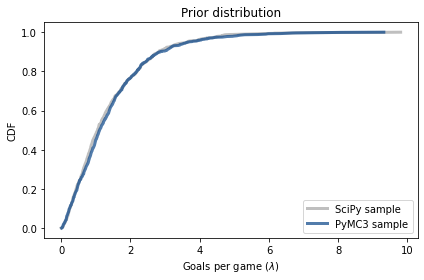

In [17]:
plot_cdf(sample_prior, 
         label='SciPy sample',
         color='C5')
plot_cdf(sample_prior_pymc, 
         label='PyMC3 sample',
         color='C0')
decorate(xlabel=r'Goals per game ($\lambda$)',
         ylabel='CDF',
         title='Prior distribution')

The results are similar, which confirms that the specification of the model is correct and the sampler works as advertised.

From the trace we can also extract `goals`, which is a sample from the prior predictive distribution.

In [18]:
sample_prior_pred_pymc = trace['goals']
sample_prior_pred_pymc.shape

(1000,)

And we can compare it to the sample we generating using the `poisson` object from SciPy.

Because the quantities in the posterior predictive distribution are discrete (number of goals) I'll plot the CDFs as step functions.

In [19]:
def plot_pred(sample, **options):
    Cdf.from_seq(sample).step(**options)

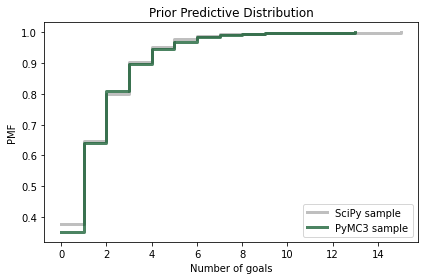

In [20]:
plot_pred(sample_prior_pred, 
          label='SciPy sample', 
          color='C5')
plot_pred(sample_prior_pred_pymc, 
          label='PyMC3 sample', 
          color='C13')
decorate(xlabel='Number of goals',
         ylabel='PMF',
         title='Prior Predictive Distribution')

Again, the results are similar, so we have some confidence we are using PyMC3 right.

## When Do We Get To Inference?

Finally, we are ready for actual inference.  We just have to make one small change.
Here is the model we used to generate the prior predictive distribution:

In [21]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

And here is the model we'll use to compute the posterior distribution.

In [22]:
with pm.Model() as model2:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam, observed=4)

The difference is that we mark goals as `observed` and provide the observed data, `4`.

And instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `lam`.

In [23]:
options = dict(return_inferencedata=False)

with model2:
    trace2 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2 seconds.


Although the specification of these models is similar, the sampling process is very different.
I won't go into the details of how PyMC3 works, but here are a few things you should be aware of:

* Depending on the model, PyMC3 uses one of several MCMC methods; in this example, it uses the [No U-Turn Sampler](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo#No_U-Turn_Sampler) (NUTS), which is one of the most efficient and reliable methods we have.

* When the sampler starts, the first values it generates are usually not a representative sample from the posterior distribution, so these values are discarded.  This process is called "tuning".

* Instead of using a single Markov chain, PyMC3 uses multiple chains.  Then we can compare results from multiple chains to make sure they are consistent.

Although we asked for a sample of 500, PyMC3 generated two samples of 1000, discarded half of each, and returned the remaining 1000.
From `trace2` we can extract a sample from the posterior distribution, like this:

In [26]:
sample_post_pymc = trace2['lam']

In [27]:
sample_post_pymc.shape

(1000,)

And we can compare the CDF of this sample to the posterior we computed by grid approximation:

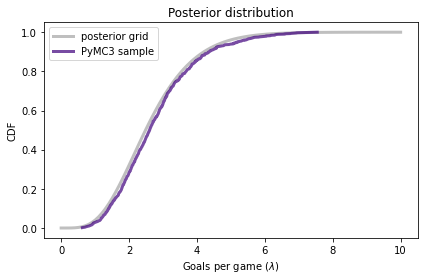

In [28]:
posterior.make_cdf().plot(label='posterior grid', 
                          color='C5')
plot_cdf(sample_post_pymc, 
         label='PyMC3 sample',
         color='C4')

decorate(xlabel=r'Goals per game ($\lambda$)',
         ylabel='CDF',
         title='Posterior distribution')

The results from PyMC3 are consistent with the results from the grid approximation.

## Posterior Predictive Distribution

Finally, to sample from the posterior predictive distribution, we can use `sample_posterior_predictive`:

In [29]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)

The result is a dictionary that contains a sample of `goals`.

In [30]:
sample_post_pred_pymc = post_pred['goals']

In [31]:
sample_post_pred_pymc.shape

(1000,)

I'll also generate a sample from the posterior distribution we computed by grid approximation.

In [32]:
sample_post = posterior.sample(1000)
sample_post_pred = poisson(sample_post).rvs()

And we can compare the two samples.

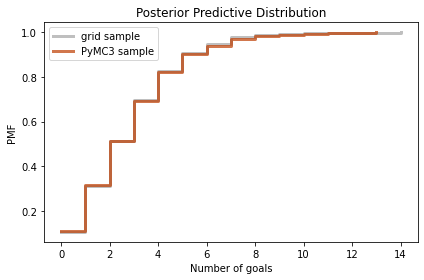

In [33]:
plot_pred(sample_post_pred, 
          label='grid sample',
          color='C5')
plot_pred(sample_post_pred_pymc, 
          label='PyMC3 sample',
          color='C12')

decorate(xlabel='Number of goals',
         ylabel='PMF',
         title='Posterior Predictive Distribution')

Again, the results are consistent.
So we've established that we can compute the same results using a grid approximation or PyMC3.

But it might not be clear why.
In this example, the grid algorithm requires less computation than MCMC, and the result is a pretty good approximation of the posterior distribution, rather than a sample.

However, this is a simple model with just one parameter.
In fact, we could have solved it with even less computation, using a conjugate prior.
The power of PyMC3 will be clearer with a more complex model.

## Happiness

Recently I read ["Happiness and Life Satisfaction"](https://ourworldindata.org/happiness-and-life-satisfaction)
by Esteban Ortiz-Ospina and Max Roser, which discusses (among many other things) the relationship between income and happiness, both between countries, within countries, and over time.

It cites the ["World Happiness Report"](https://worldhappiness.report/), which includes [results of a multiple regression analysis](https://worldhappiness.report/ed/2020/social-environments-for-world-happiness/) that explores the relationship between happiness and six potentially predictive factors:

* Income as represented by per capita GDP.

* Social support

* Healthy life expectancy at birth

* Freedom to make life choices

* Generosity

* Perceptions of corruption


The dependent variable is the national average of responses to the "Cantril ladder question" used by the [Gallup World Poll](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx):

> Please imagine a ladder with steps numbered from zero at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?

I'll refer to the responses as "happiness", but it might be more precise to think of them as a measure of satisfaction with quality of life.

In the next few sections we'll replicate the analysis in this report using Bayesian regression.

The data from this report can be [downloaded from here](https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls).

In [34]:
# Get the data file

import os

filename = 'WHR20_DataForFigure2.1.xls'
if not os.path.exists(filename):
    !wget https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls

We can use Pandas to read the data into a `DataFrame`.

In [35]:
import pandas as pd

filename = 'WHR20_DataForFigure2.1.xls'
df = pd.read_excel(filename)

In [36]:
df.head(3)

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267


In [37]:
df.shape

(153, 20)

The `DataFrame` has one row for each of 153 countries and one column for each of 20 variables.

The column called `'Ladder score'` contains the measurements of happiness we will try to predict.

In [38]:
score = df['Ladder score']

## Simple Regression

To get started, let's look at the relationship between happiness and income as represented by gross domestic product (GDP) per person.

The column named `'Logged GDP per capita'` represents the natural logarithm of GDP for each country, divided by population, corrected for [purchasing power parity](https://en.wikipedia.org/wiki/Purchasing_power_parity) (PPP).

In [39]:
log_gdp = df['Logged GDP per capita']

The following figure is a scatter plot of `score` versus `log_gdp`, with one marker for each country.

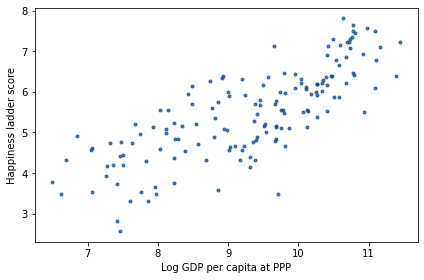

In [40]:
import matplotlib.pyplot as plt

plt.plot(log_gdp, score, '.')

decorate(xlabel='Log GDP per capita at PPP',
         ylabel='Happiness ladder score')

It's clear that there is a relationship between these variables: people in countries with higher GDP generally report higher levels of happiness.

We can use `linregress` from SciPy to compute a simple regression of these variables.

In [41]:
from scipy.stats import linregress

result = linregress(log_gdp, score)

And here are the results.

In [42]:
pd.DataFrame([result.slope, result.intercept],
             index=['Slope', 'Intercept'],
             columns=[''])

,
Slope,0.717738
Intercept,-1.198646


The estimated slope is about 0.72, which suggests that an increase of one unit in log-GDP, which is a factor of $e \approx 2.7$ in GDP, is associated with an increase of 0.72 units on the happiness ladder.

Now let's estimate the same parameters using PyMC3.
We'll use the same regression model as in Section xxx:

$$y = a x + b + \epsilon$$

where $y$ is the dependent variable (ladder score), $x$ is the predictive variable (log GDP) and $\epsilon$ is a series of values from a normal distribution with standard deviation $\sigma$.

$a$ and $b$ are the slope and intercept of the regression line.
They are unknown parameters, so we will use the data to estimate them.

The following is the PyMC3 specification of this model.

In [43]:
x_data = log_gdp
y_data = score

with pm.Model() as model3:
    a = pm.Uniform('a', 0, 4)
    b = pm.Uniform('b', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = a * x_data + b
    y = pm.Normal('y', 
                  mu=y_est, sd=sigma, 
                  observed=y_data)

The prior distributions for the parameters, `a`, `b`, and `sigma` are uniform with ranges that are wide enough to cover the posterior distributions.

`y_est` is the estimated value of the dependent variable, based on the regression equation.
And `y` is a normal distribution with mean `y_est` and standard deviation `sigma`.

Notice how the data are included in the model:

* The values of the predictive variable, `x_data`, are used to compute `y_est`.

* The values of the dependent variable, `y_data` are provided as the observed values of `y`.

Now we can use this model to generate a sample from the posterior distribution.

In [44]:
with model3:
    trace3 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 6 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6881176672776791, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


When you run the sampler, you might get warning messages about "divergences" and the "acceptance probability".
You can ignore them for now.

The result is an object that contains samples from the joint posterior distribution of `a`, `b`, and `sigma`.

In [45]:
trace3

<MultiTrace: 2 chains, 500 iterations, 6 variables>

ArviZ provides `plot_posterior`, which we can use to plot the posterior distributions of the parameters.
Here are the posterior distributions of slope, `a`, and intercept, `b`.

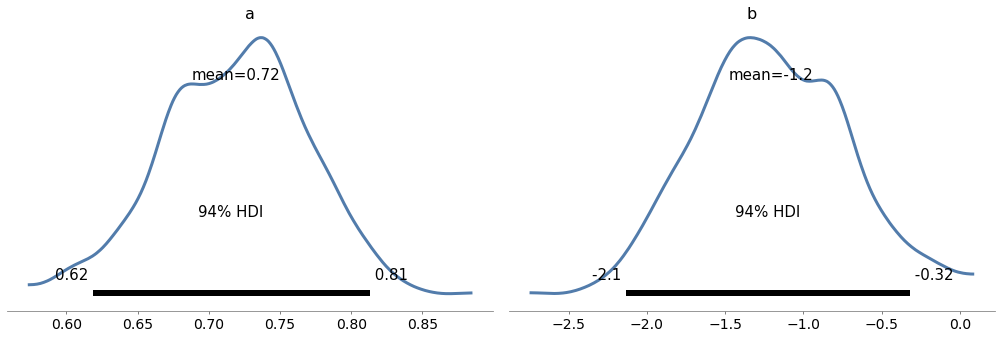

In [46]:
import arviz as az

with model3:
    az.plot_posterior(trace3, var_names=['a', 'b']);

The graphs show the distributions of the samples, estimated by KDE, and 94% credible intervals.  In the figure, "HDI" stands for ["highest-density interval"](https://www.sciencedirect.com/topics/mathematics/highest-density-interval).

The means of these samples are consistent with the parameters we estimated with `linregress`.

In [47]:
print('Sample mean:', trace3['a'].mean())
print('Regression slope:', result.slope)

Sample mean: 0.7188612567666606
Regression slope: 0.717738495630452


In [48]:
print('Sample mean:', trace3['b'].mean())
print('Regression intercept:', result.intercept)

Sample mean: -1.20698082618584
Regression intercept: -1.1986460618088843


Finally, we can check the marginal posterior distribution of `sigma`

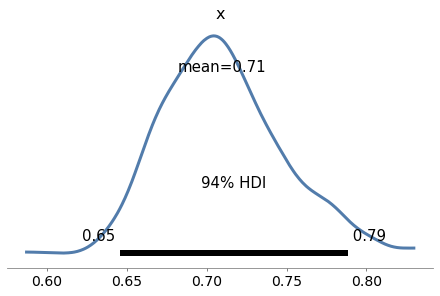

In [49]:
az.plot_posterior(trace3['sigma']);

The values in the posterior distribution of `sigma` seem plausible.

The simple regression model has only three parameters, so we could have used a grid algorithm.
But the regression model in the happiness report has six predictive variables, so it has eight parameters in total, including the intercept and `sigma`.

It is not practical to compute a grid approximation for a model with eight parameters.
Even a coarse grid, with 20 points along each dimension, would have more than 25 billion points.
And with 153 countries, we would have to compute almost 4 trillion likelihoods.

But PyMC3 can handle a model with eight parameters comfortably, as we'll see in the next section.

In [50]:
20 ** 8 / 1e9

25.6

In [51]:
153 * 20 ** 8 / 1e12

3.9168

## Multiple Regression

Before we implement the multiple regression model, I'll select the columns we need from the `DataFrame`.

In [52]:
columns = ['Ladder score',
           'Logged GDP per capita',
           'Social support',
           'Healthy life expectancy',
           'Freedom to make life choices',
           'Generosity',
           'Perceptions of corruption']

subset = df[columns]

In [53]:
subset.head(3)

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,7.8087,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445
1,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489
2,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728


The predictive variables have different units: log-GDP is in log-dollars, life expectancy is in years, and the other variables are on arbitrary scales.
To make these factors comparable, I'll standardize the data so that each variable has mean 0 and standard deviation 1.

In [54]:
standardized = (subset - subset.mean()) / subset.std()

Now let's build the model.
I'll extract the dependent variable.

In [55]:
y_data = standardized['Ladder score']

And the dependent variables.

In [56]:
x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

And here's the model.  `b0` is the intercept; `b1` through `b6` are the parameters associated with the predictive variables.

In [57]:
with pm.Model() as model4:
    b0 = pm.Uniform('b0', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y', 
                  mu=y_est, sd=sigma, 
                  observed=y_data)

We could express this model more concisely using a vector of predictive variables and a vector of parameters, but I decided to keep it simple.

Now we can sample from the joint posterior distribution.

In [58]:
with model4:
    trace4 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b6, b5, b4, b3, b2, b1, b0]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 5 seconds.


Because we standardized the data, we expect the intercept to be 0, and in fact the posterior mean of `b0` is close to 0.

In [59]:
trace4['b0'].mean()

-0.0016598920486714634

We can also check the posterior mean of `sigma`:

In [60]:
trace4['sigma'].mean()

0.5158047035433988

From `trace4` we can extract samples from the posterior distributions of the parameters and compute their means.

In [61]:
param_names = ['b1', 'b3', 'b3', 'b4', 'b5', 'b6']

means = [trace4[name].mean() 
         for name in param_names]

We can also compute 94% credible intervals (between the 3rd and 97th percentiles).

In [62]:
def credible_interval(sample):
    """Compute 94% credible interval."""
    ci = np.percentile(sample, [3, 97])
    return np.round(ci, 3)

cis = [credible_interval(trace4[name])
       for name in param_names]

The following table summarizes the results.

In [63]:
index = columns[1:]
table = pd.DataFrame(index=index)
table['Posterior mean'] = np.round(means, 3)
table['94% CI'] = cis
table

,Posterior mean,94% CI
Logged GDP per capita,0.246,"[0.077, 0.417]"
Social support,0.224,"[0.064, 0.384]"
Healthy life expectancy,0.224,"[0.064, 0.384]"
Freedom to make life choices,0.190,"[0.094, 0.291]"
Generosity,0.055,"[-0.032, 0.139]"
Perceptions of corruption,-0.098,"[-0.194, -0.002]"


It looks like GDP has the strongest association with happiness (or satisfaction), followed by social support, life expectancy, and freedom.

After controlling for those other factors, the parameters of the other factors are substantially smaller, and since the CI for generosity includes 0, it is plausible that generosity is not substantially related to happiness, at least as they were measured in this study.

This example demonstrates the power of MCMC to handle models with more than a few parameters.
But it does not really demonstrate the power of Bayesian regression.

If the goal of a regression model is to estimate parameters, there is no great advantage to Bayesian regression compared to conventional least squares regression.

Bayesian methods are more useful if we plan to use the posterior distribution of the parameters as part of a decision analysis process.

## Summary

In this chapter we used PyMC3 to implement two models we've seen before: a Poisson model of goal-scoring in soccer and a simple regression model.
Then we implemented a multiple regression model that would not have been possible to compute with a grid approximation.

MCMC is more powerful than grid methods, but that power comes with some disadvantages:

* MCMC algorithms are fiddly.  The same model might behave well with some priors and less well with others.  And the sampling process often produces warnings about tuning steps, divergences, "r-hat statistics", acceptance rates, and effective samples.  It takes some expertise to diagnose and correct these issues.

* I find it easier to develop models incrementally using grid algorithms, checking intermediate results along the way.  With PyMC3, it is not as easy to be confident that you have specified a model correctly.

For these reasons, I recommend a model development process that starts with grid algorithms and resorts to MCMC if necessary.
As we saw in the previous chapters, you can solve a lot of real-world problems with grid methods.
But when you need MCMC, it is useful to have a grid algorithm to compare to (even if it is based on a simpler model).

All of the models in this book can be implemented in PyMC3, but some of them are easier to translate than others.
In the exercises, you will have a chance to practice.

## Exercises

**Exercise:** As a warmup, let's use PyMC3 to solve the Euro problem.
Suppose we spin a coin 250 times and it comes up heads 140 times.
What is the posterior distribution of $x$, the probability of heads?

For the prior, use a beta distribution with parameters $\alpha=1$ and $\beta=1$.

See [the PyMC3 documentation](https://docs.pymc.io/api/distributions/continuous.html) for the list of continuous distributions.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2 seconds.


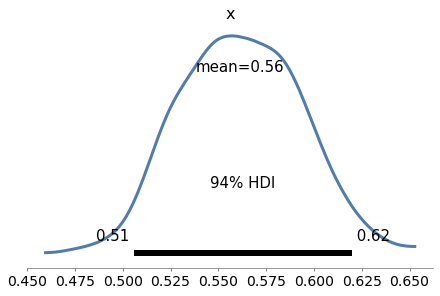

In [64]:
# Solution

n = 250
k_obs = 140

with pm.Model() as model5:
    x = pm.Beta('x', alpha=1, beta=1)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)
    trace5 = pm.sample(500, **options)
    az.plot_posterior(trace5)

**Exercise:** Now let's use PyMC3 to replicate the solution to the Grizzly Bear problem in <<_TheGrizzlyBearProblem>>, which is based on the hypergeometric distribution.

I'll present the problem with slightly different notation, to make it consistent with PyMC3.

Suppose that during the first session, `k=23` bears are tagged.  During the second session, `n=19` bears are identified, of which `x=4` had been tagged.

Estimate the posterior distribution of `N`, the number of bears in the environment.

For the prior, use a discrete uniform distribution from 50 to 500.

See [the PyMC3 documentation](https://docs.pymc.io/api/distributions/discrete.html) for the list of discrete distributions.

Note: `HyperGeometric` was added to PyMC3 after version 3.8, so you might need to update your installation to do this exercise.

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [N]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


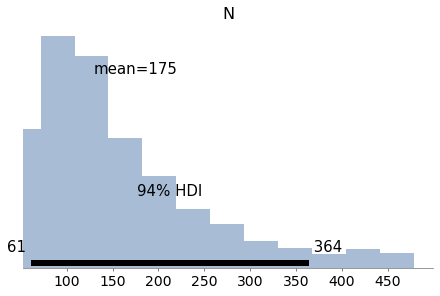

In [65]:
# Solution

k = 23
n = 19
x = 4

with pm.Model() as model6:
    N = pm.DiscreteUniform('N', 50, 500)
    y = pm.HyperGeometric('y', N=N, k=k, n=n, observed=x)
    trace6 = pm.sample(1000, **options)
    az.plot_posterior(trace6)

**Exercise:** In <<_TheWeibullDistribution>> we generated a sample from a Weibull distribution with $\lambda=3$ and $k=0.8$.
Then we used the data to compute a grid approximation of the posterior distribution of those parameters.

Now let's do the same with PyMC3.

For the priors, you can use uniform distributions as we did in <<_SurvivalAnalysis>>, or you could use `HalfNormal` distributions provided by PyMC3.

Note: The `Weibull` class in PyMC3 uses different parameters than SciPy.  The parameter `alpha` in PyMC3 corresponds to $k$, and `beta` corresponds to $\lambda$.

Here's the data again:

In [66]:
data = [0.80497283, 2.11577082, 0.43308797, 0.10862644, 5.17334866,
       3.25745053, 3.05555883, 2.47401062, 0.05340806, 1.08386395]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, lam]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


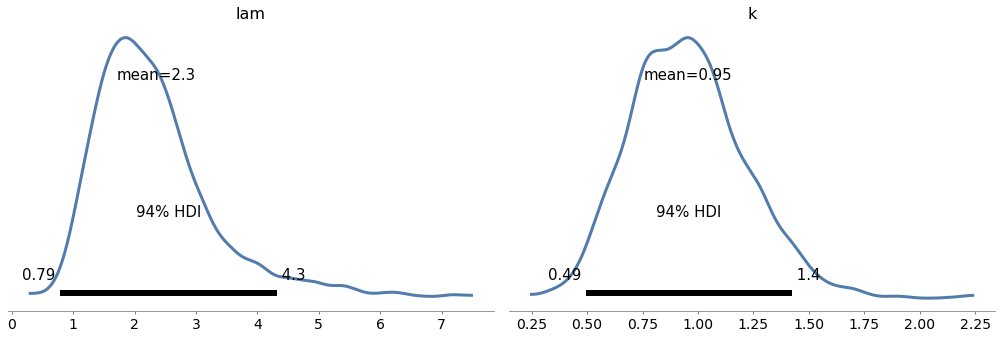

In [67]:
# Solution

with pm.Model() as model7:
    lam = pm.Uniform('lam', 0.1, 10.1)
    k = pm.Uniform('k', 0.1, 5.1)
    y = pm.Weibull('y', alpha=k, beta=lam, observed=data)
    trace7 = pm.sample(1000, **options)
    az.plot_posterior(trace7)

**Exercise:** In <<_ImprovingReadingAbility>> we used data from a reading test to estimate the parameters of a normal distribution.

Make a model that defines uniform prior distributions for `mu` and `sigma` and uses the data to estimate their posterior distributions.

Here's the data again.

In [68]:
import os

if not os.path.exists('drp_scores.csv'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv

In [69]:
import pandas as pd

df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


I'll use `groupby` to separate the treated group from the control group.

In [70]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

Now estimate the parameters for the treated group.

In [71]:
data = responses['Treated']

In [72]:
# Solution

with pm.Model() as model8:
    mu = pm.Uniform('mu', 20, 80)
    sigma = pm.Uniform('sigma', 5, 30)
    y = pm.Normal('y', mu, sigma, observed=data)
    trace8 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2 seconds.


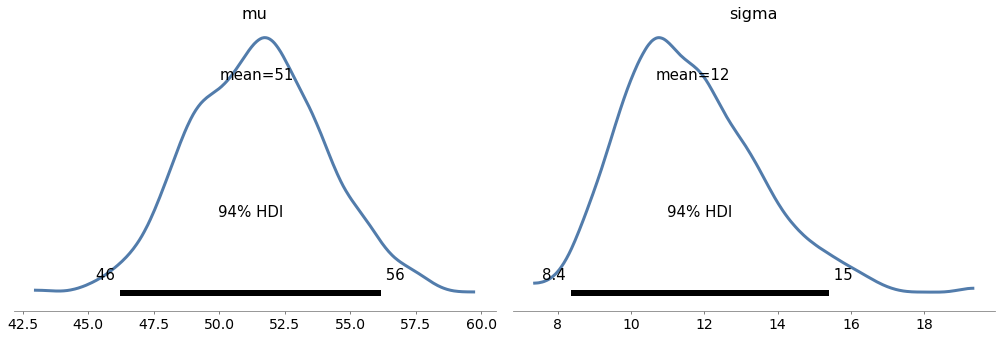

In [73]:
# Solution

with model8:
    az.plot_posterior(trace8)

**Exercise:** In <<_TheLincolnIndexProblem>> we used a grid algorithm to solve the Lincoln Index problem as presented by John D. Cook:

>"Suppose you have a tester who finds 20 bugs in your program. You
want to estimate how many bugs are really in the program. You know
there are at least 20 bugs, and if you have supreme confidence in your
tester, you may suppose there are around 20 bugs. But maybe your
tester isn't very good. Maybe there are hundreds of bugs. How can you
have any idea how many bugs there are? There's no way to know with one
tester. But if you have two testers, you can get a good idea, even if
you don't know how skilled the testers are."

Suppose the first tester finds 20 bugs, the second finds 15, and they
find 3 in common; use PyMC3 to estimate the number of bugs.

Note: This exercise is more difficult that some of the previous ones.  One of the challenges is that the data includes `k00`, which depends on `N`:

```
k00 = N - num_seen
```

So we have to construct the data as part of the model.
To do that, we can use `pm.math.stack`, which makes an array:

```
data = pm.math.stack((k00, k01, k10, k11))
```

Finally, you might find it helpful to use `pm.Multinomial`.

I'll use the following notation for the data:

* k11 is the number of bugs found by both testers,

* k10 is the number of bugs found by the first tester but not the second,

* k01 is the number of bugs found by the second tester but not the first, and

* k00 is the unknown number of undiscovered bugs.

Here are the values for all but `k00`:

In [74]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

In total, 32 bugs have been discovered:

In [75]:
num_seen = k01 + k10 + k11
num_seen

32

In [76]:
# Solution

with pm.Model() as model9:
    p0 = pm.Beta('p0', alpha=1, beta=1)
    p1 = pm.Beta('p1', alpha=1, beta=1)
    N = pm.DiscreteUniform('N', num_seen, 350)
    
    q0 = 1-p0
    q1 = 1-p1
    ps = [q0*q1, q0*p1, p0*q1, p0*p1]
    
    k00 = N - num_seen
    data = pm.math.stack((k00, k01, k10, k11))
    y = pm.Multinomial('y', n=N, p=ps, observed=data)

In [77]:
# Solution

with model9:
    trace9 = pm.sample(1000, **options)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p1, p0]
>Metropolis: [N]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8925496981550741, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


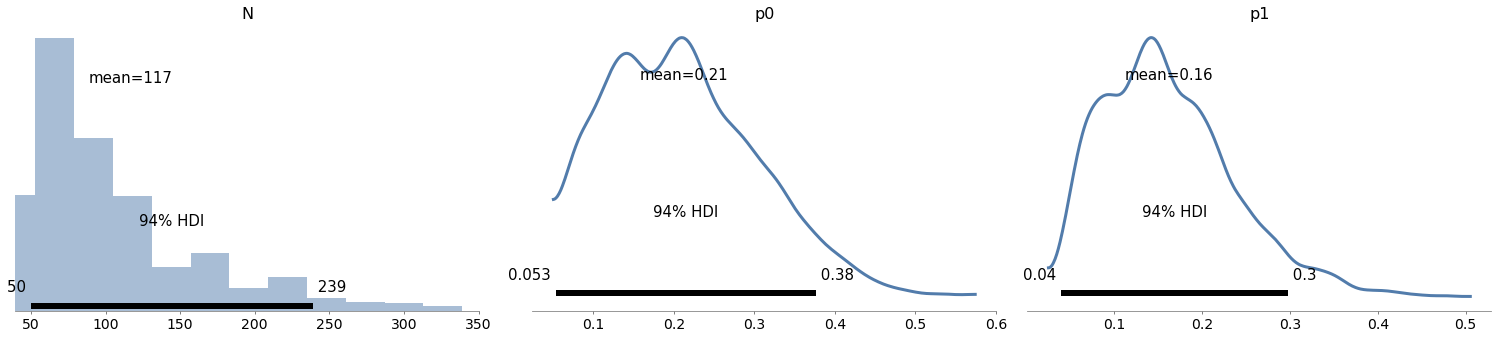

In [78]:
# Solution

with model9:
    az.plot_posterior(trace9)